In [14]:
from IPython.display import clear_output

!apt-get install libmagickwand-dev
!pip install ipython-autotime
!pip install camelot-py[cv] tabula-py
!apt-get update
!apt install ghostscript python3-tk
# !pip install sentence-transformers
!pip install pdfplumber
clear_output()  

time: 35.7 s (started: 2022-12-07 04:33:40 +00:00)


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from tabula import read_pdf
import pandas as pd
import tqdm
from tabulate import tabulate
import pdfplumber
import glob
import camelot
import os
import re
from functools import reduce
from statistics import mode
%load_ext autotime

time: 390 µs (started: 2022-12-07 04:34:29 +00:00)


In [2]:
sheet_id = "1ixtNKdaaFW8XNROXMWWveuCxHPErju5UUgwDw5PjM_w"
sheet_name = "Files_and_Type"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df = pd.read_csv(url)
all_subpaths = list(df['Full Path'])

all_paths = []
for path in all_subpaths:
  t = glob.glob(f'/content/drive/MyDrive/OCR NLP Stage 2/FSSC/Documents/**/{path}', recursive=True)
  all_paths += t

time: 1.94 s (started: 2022-12-07 04:34:29 +00:00)


In [3]:
folder_path = '/content/drive/MyDrive/otraSorted_better/otraSorted/FSSC_Audit/'
filenames = list(sorted(glob.glob('/content/drive/MyDrive/otraSorted_better/otraSorted/FSSC_Audit/*.pdf') ))

time: 5.54 ms (started: 2022-12-07 04:34:31 +00:00)


time: 873 ms (started: 2022-12-05 03:27:46 +00:00)


time: 887 ms (started: 2022-12-05 03:27:46 +00:00)


In [4]:
def keep_visible_lines(mode_value):
    """
    If the object is a ``rect`` type, keep it only if the lines are visible.

    A visible line is the one having ``non_stroking_color`` as 0.
    """
    def process(obj):
      if obj['object_type'] == 'rect':
          v = tuple(obj['non_stroking_color']) if isinstance(obj['non_stroking_color'], Iterable) else obj['non_stroking_color']
          # print(v)
          # return v == mode_value
          return v in mode_value
      return True
    return process

def get_tables_from_file(pdf_path):
  '''
  Read all tables from pdf path
  Input 
    pdf_path: <str> path to pdf file
  Return
    List of all tables, each is a pd.DataFrame object
  '''
  tables = []
  with pdfplumber.open(pdf_path) as pdf: 
    mode_value = mode(list(map(lambda x: x['non_stroking_color'], pdf.pages[0].rects)))
    filter_fn = keep_visible_lines(mode_value)
    for page_id, page in enumerate(pdf.pages):
      page = page.filter(filter_fn)
      page_tables = page.find_tables()
      tables += page_tables
    tables = list(map(lambda table: pd.DataFrame(table.extract()).fillna(''), tables))
  # list(map(lambda table: table.fillna(''), tables))
  return tables
      

time: 4.65 ms (started: 2022-12-07 04:34:31 +00:00)


In [5]:
fpath = all_paths[7]
fpath = filenames[15]
print(os.path.basename(fpath))

8bace8a2_358a_4baa_84e1_f70ee1ed9bc1_FSSC_22000_Audit_Report_Issued_211216_(1).pdf
time: 2.76 ms (started: 2022-12-07 04:34:31 +00:00)


In [6]:
def foo(e):
  dim = "height" if e["orientation"] == "v" else "width"
  return e[dim] <= 1

time: 1.32 ms (started: 2022-12-07 04:34:31 +00:00)


/content/drive/MyDrive/otraSorted_better/otraSorted/FSSC_Audit/8bace8a2_358a_4baa_84e1_f70ee1ed9bc1_FSSC_22000_Audit_Report_Issued_211216_(1).pdf


556
556
Filtered, mode value: [(0, 0, 0), (0.1294118, 0.5176471, 0.3333333)]
Counter: {(0.1294118, 0.5176471, 0.3333333): 500, (0, 0, 0): 56}
Process in case have edges


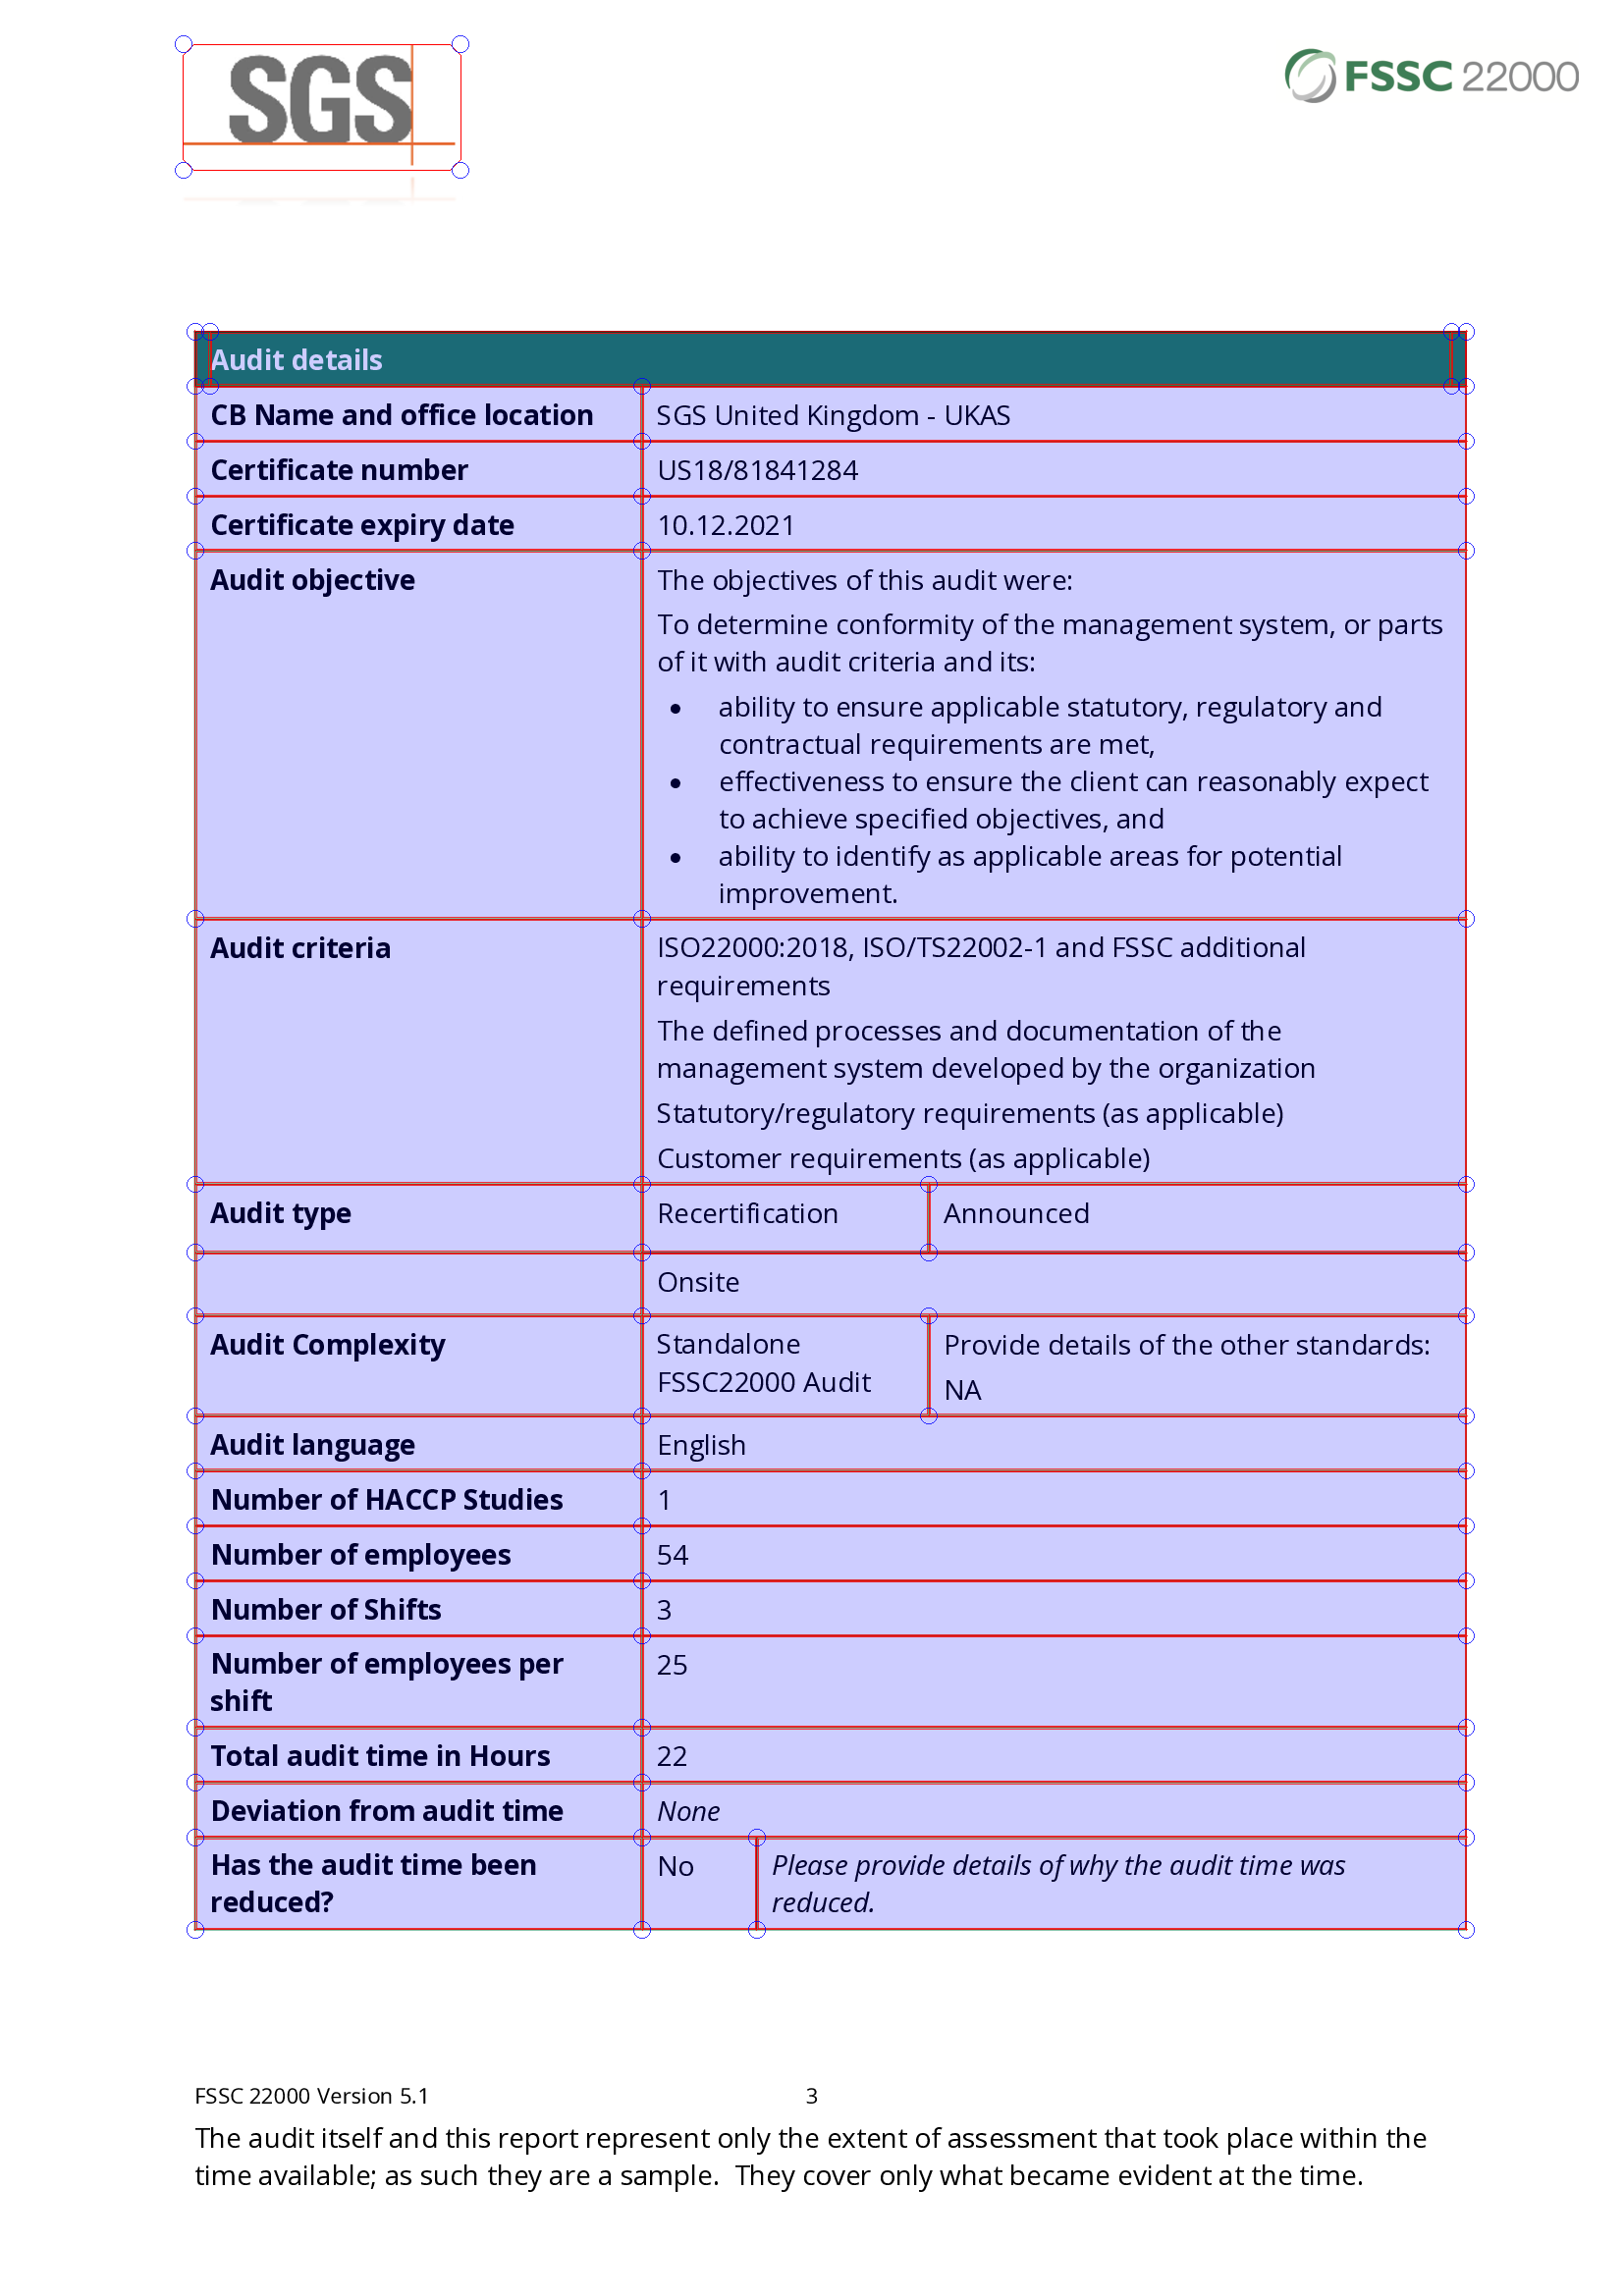

time: 6.12 s (started: 2022-12-07 04:34:36 +00:00)


In [7]:
from collections import Counter
from collections.abc import Iterable

def curves_to_edges(cs):
    edges = []
    for c in cs:
        edges += pdfplumber.utils.rect_to_edges(c)
    return edges
all_tables = []
print(fpath+ '\n\n')
with pdfplumber.open(fpath) as pdf:
  p = pdf.pages[3]
  non_strokings = list(map(lambda x: tuple(x['non_stroking_color']) if isinstance(x['non_stroking_color'], Iterable) else x['non_stroking_color'], p.edges))
  c = Counter(non_strokings)

  temp = list(filter(lambda x: foo(x), p.edges))
  non_strokings = list(map(lambda x: tuple(x['non_stroking_color']) if isinstance(x['non_stroking_color'], Iterable) else x['non_stroking_color'], temp))

  mode_value = list(dict(Counter(non_strokings)).keys())

  if len(c) > 0 and len(p.edges) > 30:

    # mode_value = [0.878, 1] 
    filter_fn = keep_visible_lines(mode_value)
    print(len(p.edges))
    p = p.filter(filter_fn)
    print(len(p.edges))

    print(f'Filtered, mode value: {mode_value}\nCounter: {dict(c)}')

  if len(p.edges) > 0:
    ts = {
      "vertical_strategy": "explicit",
      "horizontal_strategy": "explicit",
      "explicit_vertical_lines": curves_to_edges(p.curves) + p.edges,
      "explicit_horizontal_lines": curves_to_edges(p.curves) + p.edges,
    }
    print('Process in case have edges')
  else:
    ts = {
      'vertical_strategy': 'lines',
      'horizontal_strategy': 'lines'
    }
    print('Process in case without edges')
  # ts = {
  #     "vertical_strategy": "explicit",
  #     "horizontal_strategy": "explicit",
  #     "explicit_vertical_lines": curves_to_edges(p.curves) + p.edges,
  #     "explicit_horizontal_lines": curves_to_edges(p.curves) + p.edges,
  # } if len(p.edges) > 0 else {
  #     'vertical_strategy': 'lines',
  #     'horizontal_strategy': 'lines'
  # }
  # rect_x0s = [ r["x0"] for r in p.rects ]
  # rect_x1s = [ r["x1"] for r in p.rects ]

  tables = p.find_tables(table_settings=ts)
  all_tables += tables

  im = p.to_image(resolution=200)
  debugged = im.copy().debug_tablefinder(ts)

all_tables = list(map(lambda x: pd.DataFrame(x.extract()), all_tables))
debugged

In [ ]:
tables[0]

time: 19.2 ms (started: 2022-12-04 16:13:21 +00:00)


time: 10.1 ms (started: 2022-12-04 08:13:26 +00:00)


In [ ]:
# temp = list(filter(lambda x: x['non_stroking_color'] == 0.749 and foo(x), p.edges))
temp = list(filter(lambda x: foo(x), p.edges))
non_strokings = list(map(lambda x: tuple(x['non_stroking_color']) if isinstance(x['non_stroking_color'], Iterable) else x['non_stroking_color'], temp))

dict(Counter(non_strokings)).keys()

dict_keys([(0, 0, 0)])

time: 8.28 ms (started: 2022-12-04 06:56:57 +00:00)


In [ ]:
tables

time: 19.1 ms (started: 2022-12-05 03:44:08 +00:00)


In [ ]:
len(tables)

4

time: 3.75 ms (started: 2022-12-05 03:43:51 +00:00)


In [ ]:
print(pd.DataFrame(tables[0].extract()).to_markdown(tablefmt='grid'))

+----+--------------------------------------+-----------------------------------------------------------------------+-----------------------------+
|    | 0                                    | 1                                                                     | 2                           |
+====+======================================+=======================================================================+=============================+
|  0 | Name 1 (role)                        | Alexander Moraga (Lead Auditor)                                       |                             |
+----+--------------------------------------+-----------------------------------------------------------------------+-----------------------------+
|  1 | Audit  objective  (from  the  audit  | Recertification Audits – Evaluation the continued fulfilment of all   |                             |
|    | plan)                                | the requirements of the relevant management system standard       

In [ ]:
p.curves

In [ ]:
edges = pdfplumber.utils.filter_edges(p.edges)

print(len(p.edges))
print(len(edges))

non_strokings = list(map(lambda x: tuple(x['non_stroking_color']) if isinstance(x['non_stroking_color'], Iterable) else x['non_stroking_color'], edges))
Counter(non_strokings)

1640
844


Counter({0.949: 180, 1: 308, 0.753: 284, 0.749: 72})

time: 13.8 ms (started: 2022-12-04 04:36:05 +00:00)


In [ ]:
def foo(e):
  dim = "height" if e["orientation"] == "v" else "width"
  return e[dim] <= 1

def get_tables_from_file(pdf_path):
  '''
  Read all tables from pdf path
  Input 
    pdf_path: <str> path to pdf file
  Return
    List of all tables, each is a pd.DataFrame object
  '''
  tables = []
  with pdfplumber.open(pdf_path) as pdf: 
    for page_id, page in enumerate(pdf.pages):

      temp = list(filter(lambda x: foo(x), page.edges))
      non_strokings = list(map(lambda x: tuple(x['non_stroking_color']) if isinstance(x['non_stroking_color'], Iterable) else x['non_stroking_color'], temp))

      mode_value = list(dict(Counter(non_strokings)).keys())

      if len(page.edges) > 20:
        # print(mode_value)
        filter_fn = keep_visible_lines(mode_value)
        page = page.filter(filter_fn)
      
      ts = {
        "vertical_strategy": "explicit",
        "horizontal_strategy": "explicit",
        "explicit_vertical_lines": curves_to_edges(page.curves) + page.edges,
        "explicit_horizontal_lines": curves_to_edges(page.curves) + page.edges,
      } if len(page.curves + page.edges) > 0 else {
        "vertical_strategy": "lines",
        "horizontal_strategy": "lines",
      }
      page_tables = page.find_tables(ts)
      tables += page_tables
    tables = list(map(lambda table: pd.DataFrame(table.extract()).fillna(''), tables))
  return tables

def get_trigrams(string):
    """
    Take a string and return a list of 3-grams.
    """
    s = string.strip().lower()
    return [s[i:i+3] for i in list(range(len(s) - 2))]


def string_similarity(str1, str2):
    """
    Perform bigram comparison between two strings
    and return a percentage match in decimal form.
    Input:
      str1: <str> key extracted from table
      str2: <str> keyword
    Return <float> score of similar between 2 strings
    """
    str1 = re.sub('[^A-Za-z0-9]+', '', str1.replace('\n', ''))
    str2 = re.sub('[^A-Za-z0-9]+', '', str2.replace('\n', ''))
    pairs1 = get_trigrams(str1)
    pairs2 = get_trigrams(str2)
    union = len(pairs1) + len(pairs2)
    hit_count = 0
    i = 0
    while i < len(pairs1):
      j = 0
      while j < len(pairs2):
        if pairs1[i] == pairs2[j]:
          pairs1.pop(i)
          pairs2.pop(j)
          hit_count += 1
          # s = True
          if i >= len(pairs1):break
        else:
          j += 1
      i += 1
        
    return (2.0 * hit_count) / union if union != 0 else 0
    
from dateutil import parser
def get_expiration_date_value(tables, keys, threshold=0.8):
  max_score = 0
  result = None
  t = ''
  all_dates = []

  for table in tables:
    for i in range(len(table)):
      temp = np.array(list(table.iloc[i]))
      temp = list(temp[temp != ''])
      for j in range(len(temp)):
        scores = list(map(lambda x: string_similarity(temp[j], x), keys))
        if max(scores) >= max_score and j < len(temp)-1:
          max_score = max(scores)
          if len(temp[j+1:]) < 3:
            try:
              # result = parser.parse(' '.join(temp[j+1:]), fuzzy=True).strftime("%m/%d/%Y")
              result = parser.parse(' '.join(temp[j+1:]), fuzzy=True)
              if max_score > threshold:
                all_dates += [ result ]
            except: pass
          else:
            try:
              # result = parser.parse(temp[j+1], fuzzy=True).strftime("%m/%d/%Y")
              result = parser.parse(temp[j+1], fuzzy=True)
              if max_score > threshold:
                all_dates += [ result ]
            except: pass
          t = temp[j]
  if max_score > threshold and len(all_dates) > 0:
    # return max(all_dates).strftime("%m/%d/%Y"), max_score
    return max(all_dates), max_score
  return None, None

expiration_date_keys = ['Expiration Date', 'Expiry date', 'Certificate expiry date', 'Registration']

      

time: 7.94 ms (started: 2022-12-05 03:38:22 +00:00)


In [ ]:
fpath = filenames[16]
tables = get_tables_from_file(fpath)
expiration_date, expr_date_score = get_expiration_date_value(tables, expiration_date_keys, threshold=0.8)


time: 6.23 s (started: 2022-12-05 03:38:25 +00:00)


In [ ]:
expiration_date

datetime.datetime(1111, 11, 11, 0, 0)

time: 14.5 ms (started: 2022-12-04 16:11:20 +00:00)
